In [1]:
import sys
sys.path.append('/Users/leah/Columbia/courses/19summer/SocialBehavior/SocialBehaviorptc')

In [2]:
from ssm_ptc.models.hmm import HMM
from ssm_ptc.distributions.truncatednormal import TruncatedNormal
from ssm_ptc.utils import find_permutation, random_rotation, k_step_prediction

from project_ssms.ar_truncated_normal_observation import ARTruncatedNormalObservation
from project_ssms.coupled_transformations.grid_transformation import GridTransformation
from project_ssms.single_transformations import single_direction_transformation
from project_ssms.feature_funcs import feature_direction_vec
from project_ssms.momentum_utils import filter_traj_by_speed, get_momentum_in_batch
from project_ssms.utils import k_step_prediction_for_grid_model
from project_ssms.plot_utils import plot_z, plot_2_mice, plot_4_traces

import torch
import numpy as np
import numpy.random as npr
import matplotlib.pyplot as plt

import seaborn as sns
sns.set_style("white")
sns.set_context("talk")

#from tqdm import trange
from tqdm import tqdm_notebook as tqdm

import time

import joblib

# data

In [3]:
trajs_all = joblib.load("trajs_all")

In [4]:
trajs = trajs_all[36000*0:36000*1]

In [5]:
f_trajs = filter_traj_by_speed(trajs, q1=0.9, q2=0.9)

In [6]:
diff = np.diff(f_trajs, axis=0)

In [7]:
np.max(abs(diff), axis=0)

array([10.13334823, 10.94461803, 21.90342061, 13.61125601])

In [8]:
np.max(trajs, axis=0)

array([312.4153142 , 366.82321405, 299.37139297, 379.03557754])

In [9]:
arena_xmin = 10
arena_xmax = 320
arena_ymin = -10
arena_ymax = 390

In [10]:
# make 3 by 3 grid world
x_grid_gap = (arena_xmax - arena_xmin) / 3
y_grid_gap = (arena_ymax - arena_ymin) / 3

In [11]:
x_grids = [arena_xmin + i * x_grid_gap for i in range(4)]
y_grids = [arena_ymin + i * y_grid_gap for i in range(4)]

In [12]:
bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])

In [13]:
bounds

array([[ 10, 320],
       [-10, 390],
       [ 10, 320],
       [-10, 390]])

In [14]:
def plot_grid():
    plt.scatter([10,10,320,320],[-10,390,-10,390])
    for j in range(4):
        plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

    for i in range(4):
        plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

        
def ax_grid(ax):
    ax.scatter([10,10,320,320],[-10,390,-10,390])
    for j in range(4):
        ax.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

    for i in range(4):
        ax.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

In [15]:
CORNERS = torch.tensor([[10, -10], [10, 390], [320, -10], [320, 390]], dtype=torch.float64)

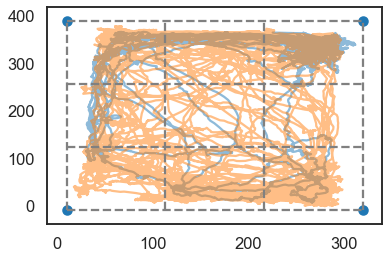

In [16]:
plot_2_mice(trajs, alpha=0.5)
plot_grid()

In [17]:
def plot_realdata_quiver(realdata, scale=0.3, alpha=0.8, xlim=None, ylim=None):
    assert isinstance(realdata, np.ndarray), "please input ndarray"
    start = realdata[:-1]
    end = realdata[1:]
    dXY = end - start
    
    plt.subplot(1,2,1)
    plt.quiver(start[:, 0], start[:, 1], dXY[:, 0], dXY[:, 1],
                         angles='xy', scale_units='xy', scale=scale, alpha=alpha)
    plot_grid()
    plt.title("virgin")
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

    plt.subplot(1,2,2)
    plt.quiver(start[:, 2], start[:, 3], dXY[:, 0], dXY[:, 1],
                         angles='xy', scale_units='xy', scale=scale, alpha=alpha)
    plot_grid()
    plt.title("mother")
    if xlim is not None:
        plt.xlim(xlim)
    if ylim is not None:
        plt.ylim(ylim)

In [18]:
data = torch.tensor(trajs, dtype=torch.float64)

In [46]:
def f_corner_vec_func(s):
    return feature_direction_vec(s, CORNERS)

# model

In [19]:
torch.manual_seed(0)
np.random.seed(0)

D = 4
K = 2
M = 0

Df = 4

f_corner_vec_func = lambda s: feature_direction_vec(s, CORNERS)

bounds = np.array([[arena_xmin, arena_xmax], [arena_ymin, arena_ymax], 
                   [arena_xmin, arena_xmax], [arena_ymin, arena_ymax]])


tran = GridTransformation(K=K, D=D, x_grids=x_grids, y_grids=y_grids, single_transformation="direction",
                          Df=Df, feature_vec_func=f_corner_vec_func, acc_factor=10)

# compute memories
masks_a, masks_b = tran.get_masks(data[:-1])
feature_vecs_a = f_corner_vec_func(data[:-1, 0:2])
feature_vecs_b = f_corner_vec_func(data[:-1, 2:4])

m_kwargs_a = dict(feature_vecs=feature_vecs_a)
m_kwargs_b = dict(feature_vecs=feature_vecs_b)

obs = ARTruncatedNormalObservation(K=K, D=D, M=M, lags=1, bounds=bounds, transformation=tran)

# model
model = HMM(K=K, D=D, M=M, observation=obs)


In [20]:
model.observation.mus_init = data[0] * torch.ones(K, D, dtype=torch.float64)

In [21]:
log_prob = model.log_likelihood(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

In [22]:
log_prob

tensor(-2168016.8139, dtype=torch.float64, grad_fn=<AddBackward0>)

# training

In [23]:
##################### training ############################

num_iters = 8000
losses, opt = model.fit(data, num_iters=num_iters, lr=0.005, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

iter 7990 loss 232442.54: 100%|██████████| 8000/8000 [57:24<00:00,  2.32it/s]


In [23]:
params = joblib.load("model_k2")

In [24]:
model.params = params

In [25]:
model.log_likelihood(data)

tensor(-232439.5211, dtype=torch.float64, grad_fn=<AddBackward0>)

In [26]:
print("inferiring most likely states...")
z = model.most_likely_states(data, masks=(masks_a, masks_b),
                                  memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

inferiring most likely states...


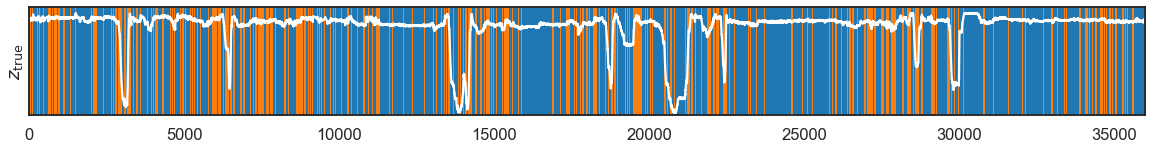

In [27]:
plot_z(z, ylim=(0, 390))
plt.plot(data[:,1].numpy(), color='white')

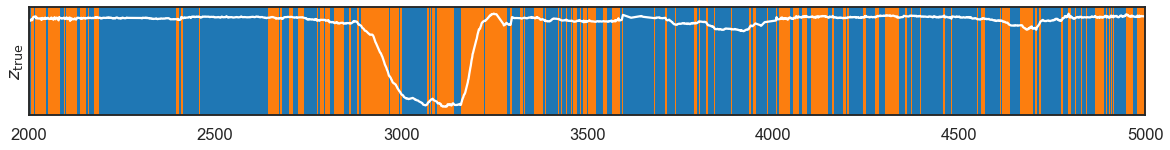

In [28]:
plot_z(z, plot_range=(2000,5000), ylim=(0, 390))
plt.plot(data[:,1].numpy(), color='white')

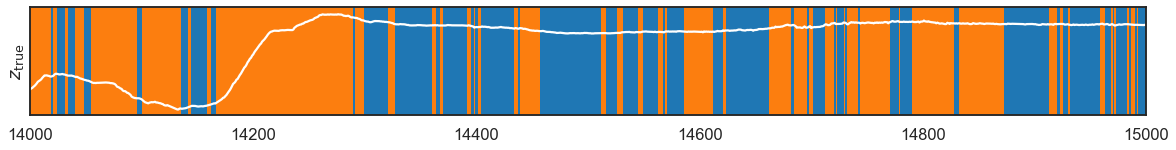

In [29]:
plot_z(z, plot_range=(14000,15000), ylim=(0, 390))
plt.plot(data[:,1].numpy(), color='white')

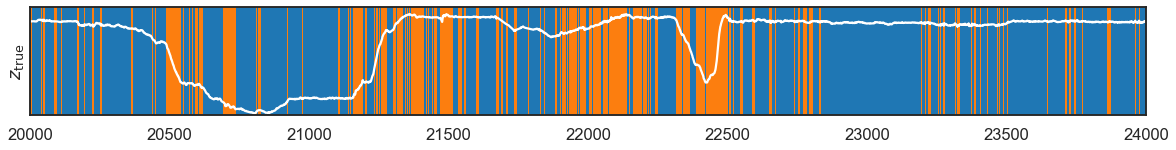

In [30]:
plot_z(z, plot_range=(20000,24000), ylim=(0, 390))
plt.plot(data[:,1].numpy(), color='white')

In [31]:
print("0 step prediction")
x_predict = k_step_prediction_for_grid_model(model, z, data, memory_kwargs_a=m_kwargs_a, memory_kwargs_b=m_kwargs_b)

0 step prediction


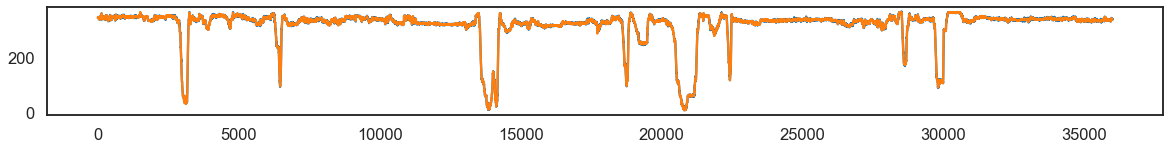

In [32]:
plt.figure(figsize=(20,2))
plt.plot(x_predict[:,1])
plt.plot(data[:,1].numpy())

In [33]:
np.mean(np.abs(x_predict-data.numpy()), axis=0)

array([1.20287978, 1.2097821 , 1.77810053, 1.76681903])

# sample

In [34]:
model.init_dist

tensor([9.9987e-01, 1.3200e-04], dtype=torch.float64,
       grad_fn=<SoftmaxBackward>)

In [36]:
model.observation.mus_init

tensor([[272.1539, 345.7538, 232.6721, 303.0308],
        [272.1539, 345.7538, 232.6721, 303.0308]], dtype=torch.float64)

In [37]:
sample_z, sample_x = model.sample(3600)

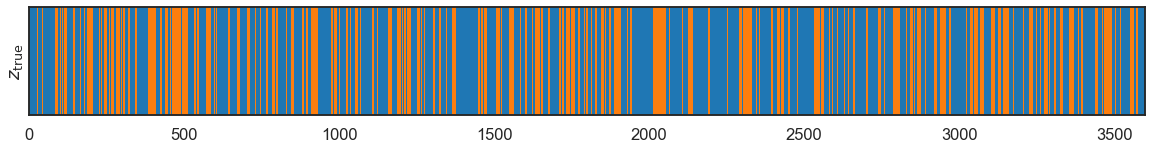

In [38]:
plot_z(sample_z)

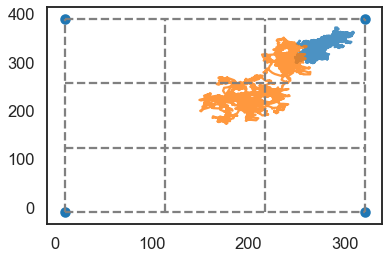

In [39]:
plot_2_mice(sample_x)
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

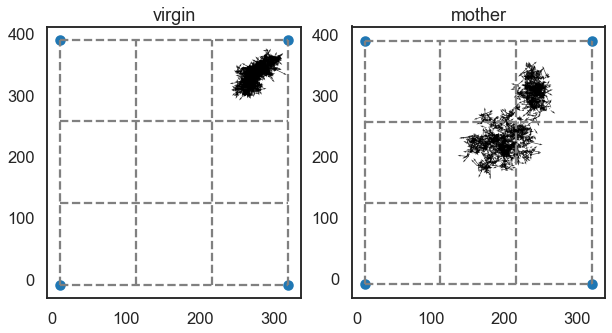

In [40]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x)

In [34]:
center_z = torch.tensor([0], dtype=torch.int)
center_x = torch.tensor([[150, 190, 200, 200]], dtype=torch.float64)

In [44]:
sample_z_center, sample_x_center = model.sample(36000, prefix=(center_z, center_x))

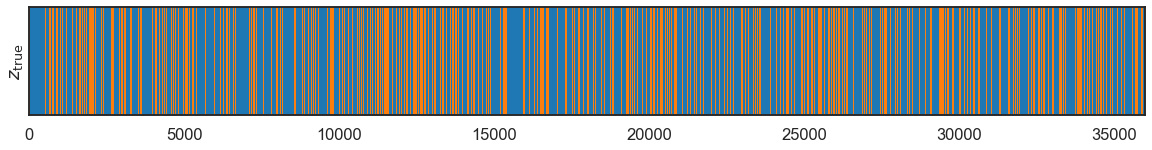

In [42]:
plot_z(sample_z_center)

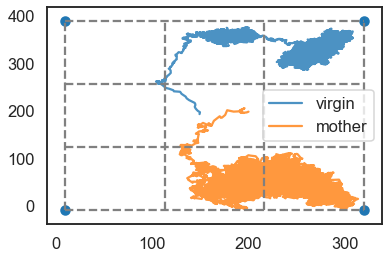

In [43]:
plot_2_mice(sample_x_center)
plt.legend()
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

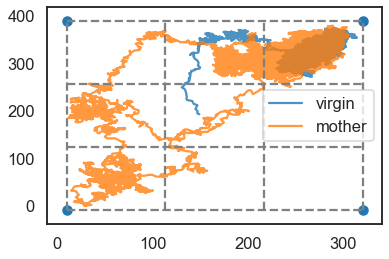

In [45]:
plot_2_mice(sample_x_center)
plt.legend()
plt.scatter([10,10,320,320],[-10,390,-10,390])
for j in range(4):
    plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')

for i in range(4):
    plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')

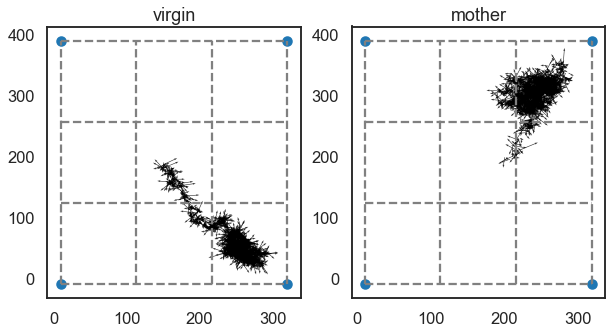

In [79]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center, scale=0.2)

In [31]:
# check speed
out = np.diff(sample_x, axis=0)

In [32]:
np.max(abs(out), axis=0)

array([ 7.14287647,  7.62969952, 14.84415932, 15.00684261])

In [48]:
torch.exp(obs.log_sigmas)

tensor([[0.7253, 0.7022, 0.9184, 0.8498],
        [1.8917, 1.9587, 3.1338, 3.1838]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [49]:
speed = np.diff(trajs, axis=0)

In [50]:
np.average(np.abs(speed), axis=0)

array([0.76620635, 0.78358849, 1.16686396, 1.14097278])

# dynamics

In [34]:
plot_to_grid = {1:2, 2:5, 3: 8, 4: 1, 5: 4, 6: 7, 7:0, 8:3, 9:6}

In [35]:
def plot_weights(weights, Df):
    plt.figure(figsize=(16, 12))
    
    gap = 0.4 / (K-1)
    
    for plot_idx, grid_idx in plot_to_grid.items():
        plt.subplot(3,3,plot_idx)
        plt.title("Grid {}".format(grid_idx))
        for k in range(K):
            plt.bar(np.arange(Df) - 0.2 + k*gap, weights[grid_idx][k], width=.4, label='k={}'.format(k))
        plt.plot([0, Df], [0, 0], '-k')
        plt.ylim(0, 10)
        plt.xticks(np.arange(0,Df,1), ["lower L", "upper L", "lower R", "upper R"])
        plt.grid()
        plt.legend()

    plt.tight_layout()

In [36]:
weights_a = 10 * np.array([torch.sigmoid(t.Ws.detach()).numpy() for t in tran.transformations_a])
weights_b = 10 * np.array([torch.sigmoid(t.Ws.detach()).numpy() for t in tran.transformations_b])

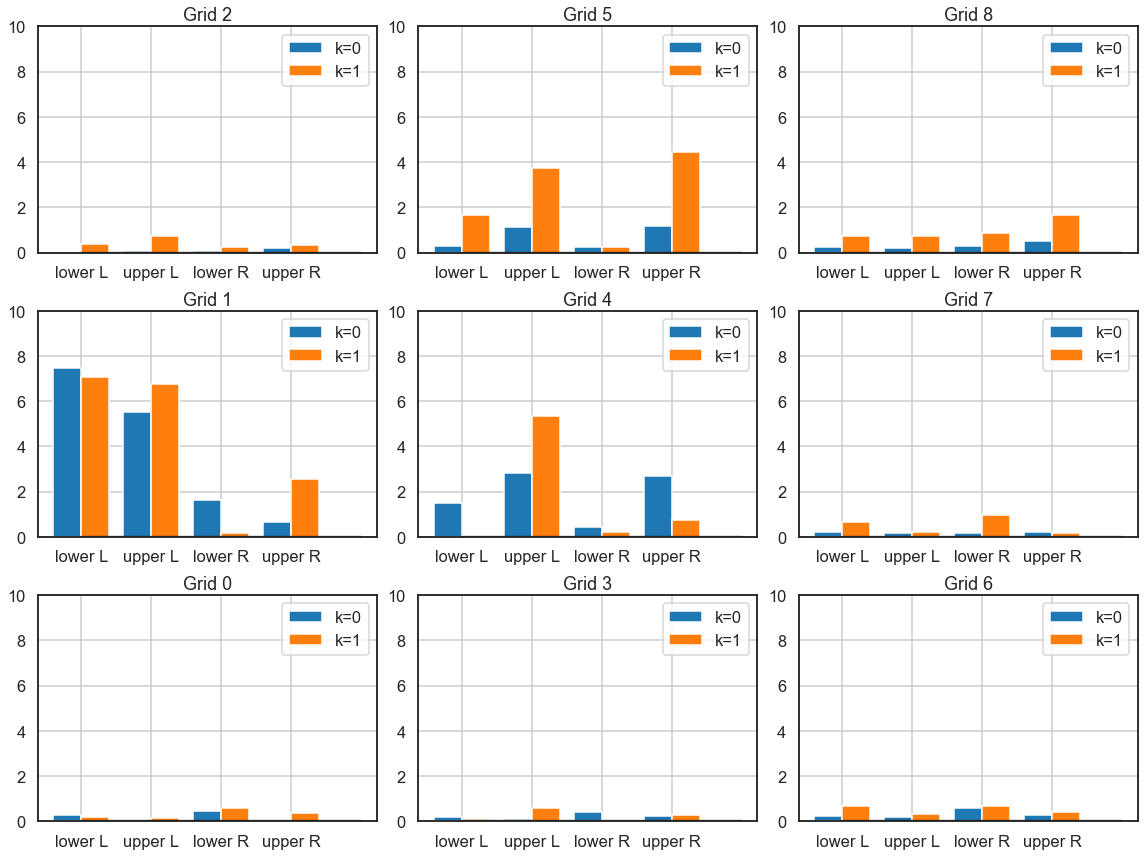

In [37]:
plot_weights(weights_a, Df=4)

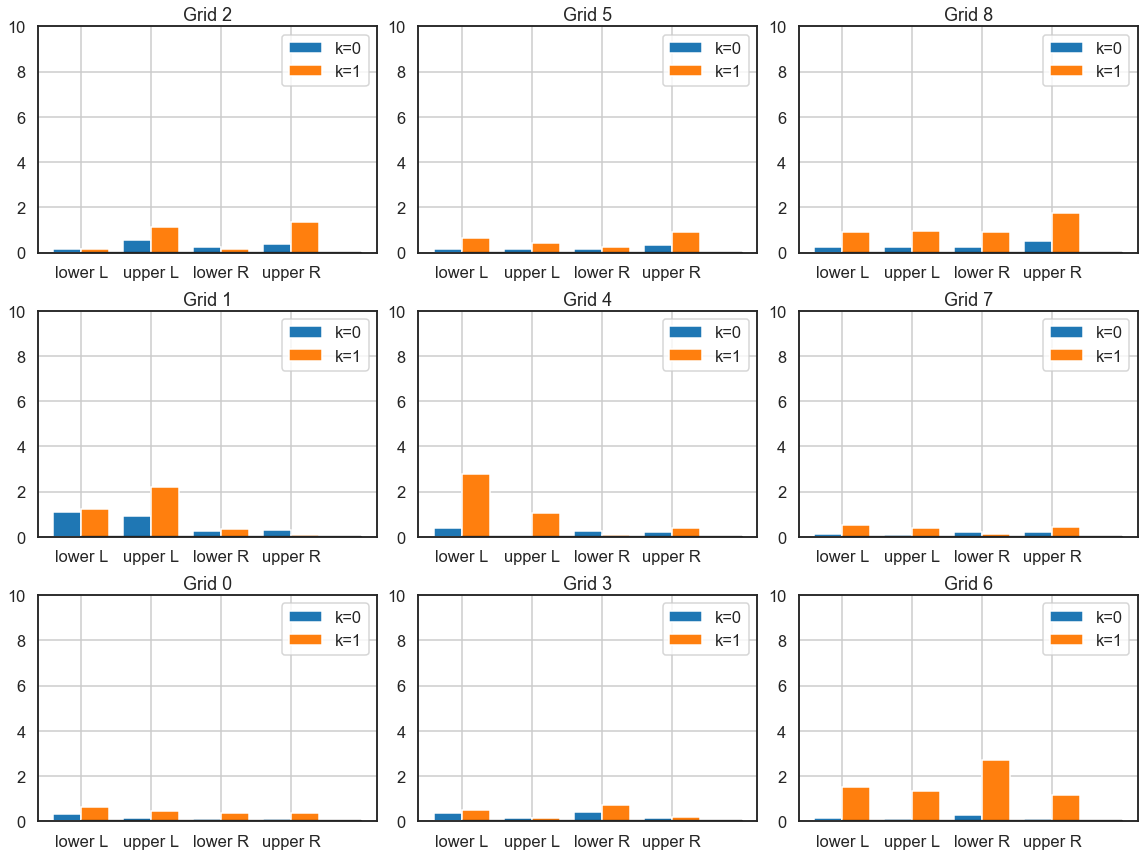

In [38]:
plot_weights(weights_b, Df=4)

In [39]:
CORNERS

tensor([[ 10., -10.],
        [ 10., 390.],
        [320., -10.],
        [320., 390.]], dtype=torch.float64)

In [40]:
grid_centers = np.array([[1/2*(x_grids[i] + x_grids[i+1]), 1/2*(y_grids[j] + y_grids[j+1])] for i in range(3) for j in range(3)])

In [41]:
out = f_corner_vec_func(torch.tensor(grid_centers, dtype=torch.float64))
corner_vecs = out.numpy()
# (G, 1, Df, d) * (G, K, Df, 1) --> (G, K, Df, d) 
weighted_corner_vecs_a = corner_vecs[:, None] * weights_a[..., None]
weighted_corner_vecs_b = corner_vecs[:, None] * weights_b[..., None]

In [42]:
def plot_dynamics(weighted_corner_vecs, animal, scale=0.1):
    result_corner_vecs = np.sum(weighted_corner_vecs, axis=2)
    
    plt.figure(figsize=(20,10))
    
    def plot_dynamics_k(k):
        for j in range(4):
            plt.plot([x_grids[0], x_grids[-1]], [y_grids[j], y_grids[j]], '--', color='grey')
        for i in range(4):
            plt.plot([x_grids[i], x_grids[i]], [y_grids[0], y_grids[-1]], '--', color='grey')
        plt.scatter(CORNERS[:,0], CORNERS[:,1], s=80)

        for df in range(Df):
            plt.quiver(grid_centers[:,0], grid_centers[:,1], weighted_corner_vecs[:,k,df,0], weighted_corner_vecs[:,k,df,1], 
                       units='xy', scale=scale, width=2, alpha=0.5)

        plt.quiver(grid_centers[:,0], grid_centers[:,1], result_corner_vecs[:,k,0], result_corner_vecs[:,k,1],
                      units='xy', scale=scale, width=2, color='red',alpha=0.5)
        plt.title("K={}, ".format(k) + animal, fontsize=20)
        
    plt.subplot(1,2,1)
    plot_dynamics_k(0)
    plt.subplot(1,2,2)
    plot_dynamics_k(1)
    
    plt.tight_layout()

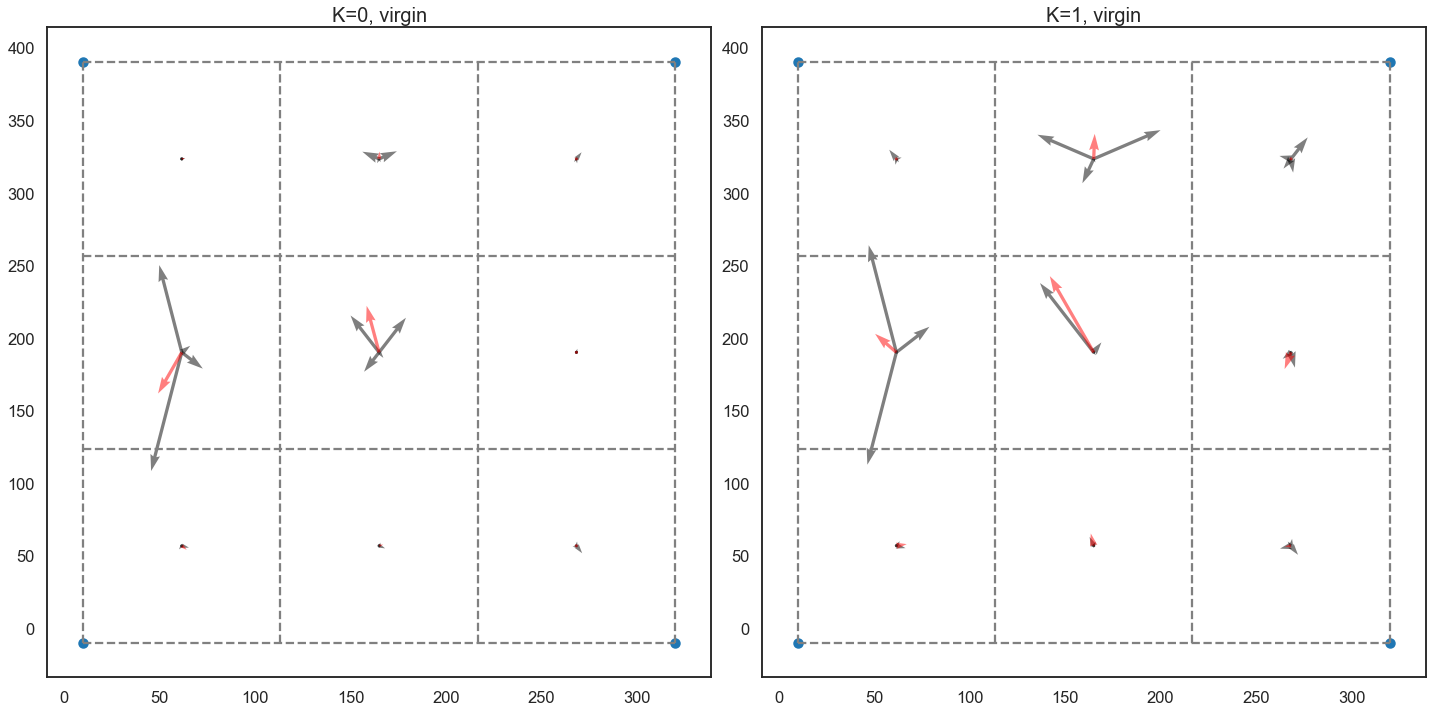

In [43]:
plot_dynamics(weighted_corner_vecs_a, "virgin")

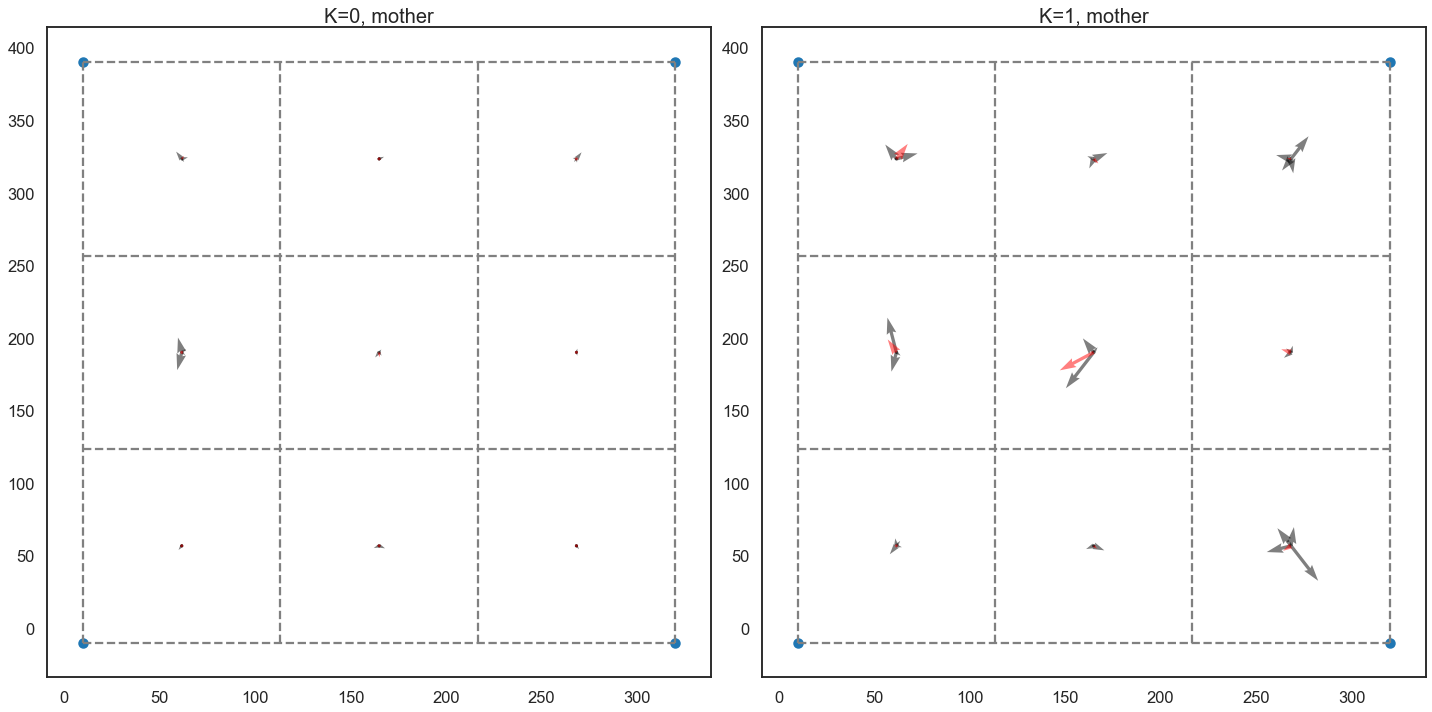

In [44]:
plot_dynamics(weighted_corner_vecs_b, "mother")

In [57]:
def plot_quiver(XYs, dXYs, mouse, scale=1, alpha=1, p_grid=True):
    if mouse == 'virgin':
        i = 0
        j = 1
    elif mouse == 'mother':
        i = 2
        j = 3

    fig, axs = plt.subplots(1, 2, figsize=(12, 4))
    
    for k in range(K):
        axs[k].quiver(XYs[:, i], XYs[:, j], dXYs[:, k, i], dXYs[:, k, j],
                     angles='xy', scale_units='xy', scale=scale, alpha=alpha)
        axs[k].set_title('K={} '.format(k) + mouse)
        if p_grid:
            ax_grid(axs[k])

    plt.tight_layout()


In [58]:
# quiver
XX, YY = np.meshgrid(np.linspace(20, 310, 30), 
                     np.linspace(0, 380, 30))
XY = np.column_stack((np.ravel(XX), np.ravel(YY))) # shape (900,2) grid values

In [87]:
x_grids

[10.0, 113.33333333333333, 216.66666666666666, 320.0]

In [90]:
y_grids

[-10.0, 123.33333333333334, 256.6666666666667, 390.0]

In [59]:
XY_grids = np.concatenate((XY, XY), axis=1)

XY_next = tran.transform(torch.tensor(XY_grids, dtype=torch.float64))
dXY = XY_next.detach().numpy() - XY_grids[:, None]


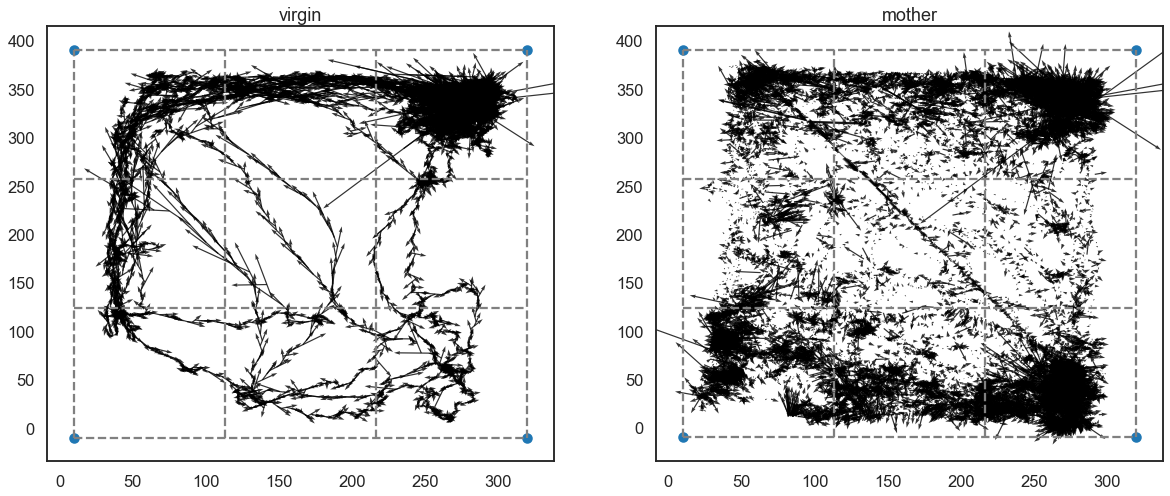

In [60]:
plt.figure(figsize=(20,8))

plot_realdata_quiver(data.numpy())

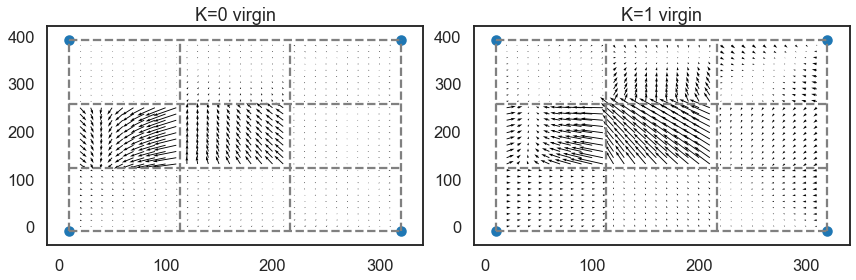

In [61]:
plot_quiver(XY_grids, dXY, 'virgin', scale=0.2)

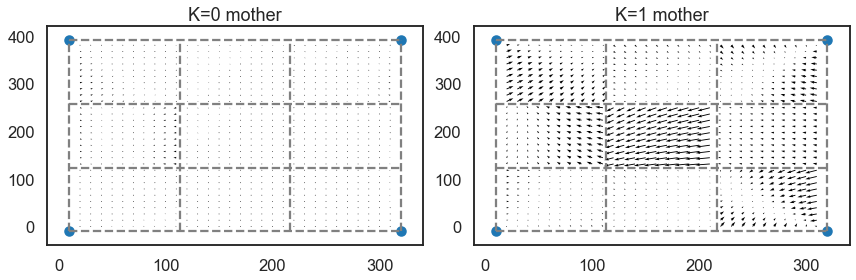

In [62]:
plot_quiver(XY_grids, dXY, 'mother', scale=0.2)

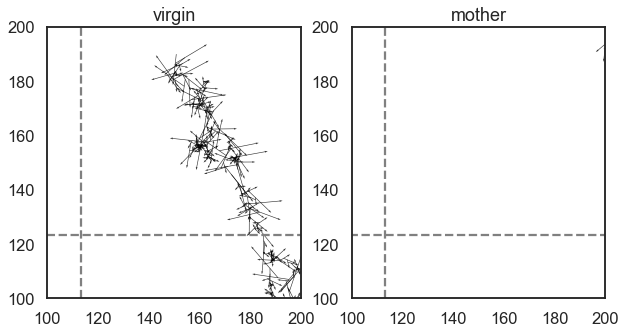

In [81]:
plt.figure(figsize=(10,5))
plot_realdata_quiver(sample_x_center, xlim=[100,200], ylim=[100,200], scale=0.3)

In [261]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7253, 0.7022, 0.9184, 0.8498],
        [1.8917, 1.9587, 3.1338, 3.1838]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [309]:
model.observation.bounds.shape

torch.Size([4, 2])

In [310]:
model.observation.bounds

tensor([[ 10., 320.],
        [-10., 390.],
        [ 10., 320.],
        [-10., 390.]], dtype=torch.float64)

In [320]:
torch.rand(1)

tensor([0.1918])

In [33]:
trajs_all.shape

(1080000, 4)

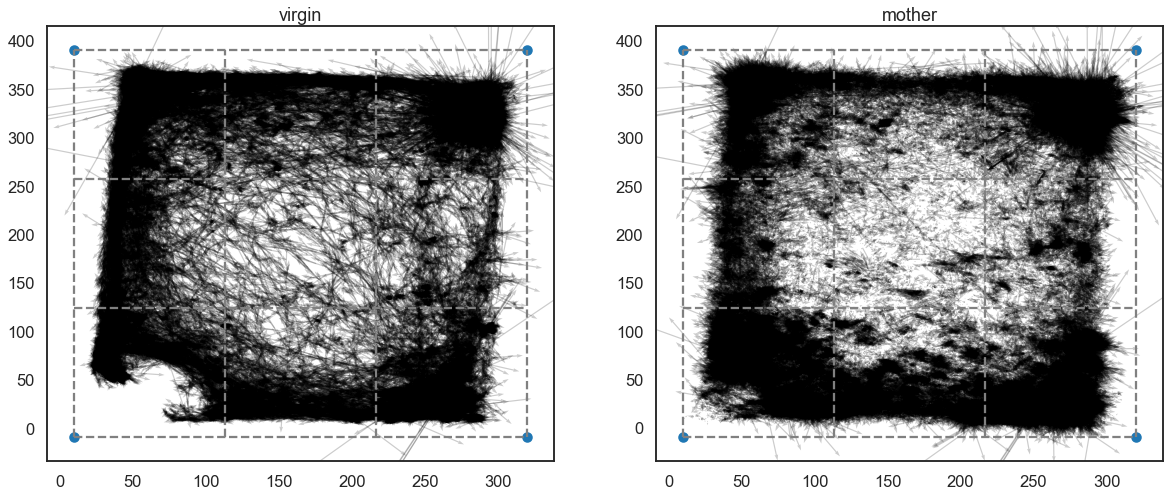

In [39]:
plt.figure(figsize=(20,8))
plot_realdata_quiver(trajs_all, alpha=0.2)

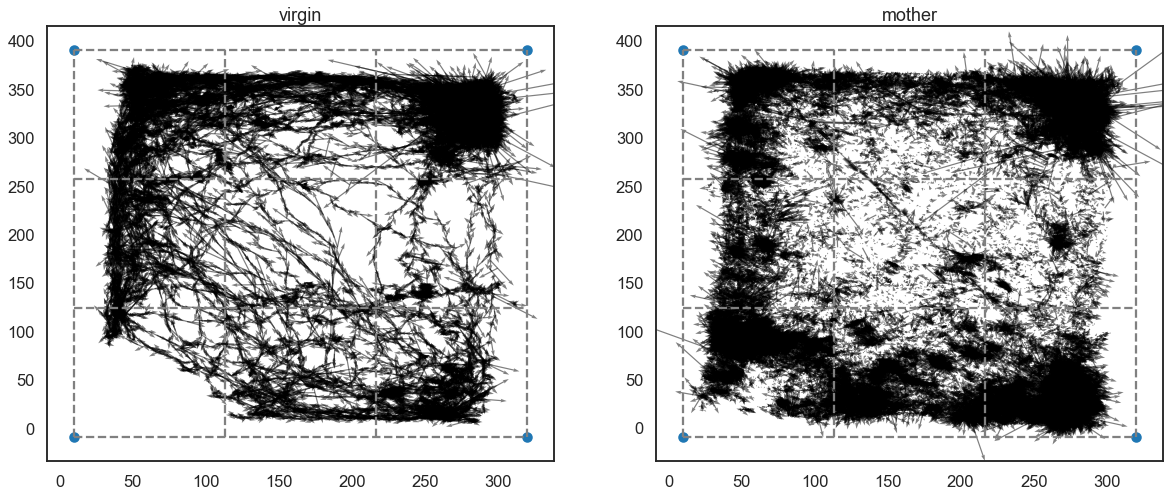

In [38]:
plt.figure(figsize=(20,8))
plot_realdata_quiver(trajs_all[:36000*5], alpha=0.5)

In [40]:
diff.shape

(35999, 4)

In [52]:
diff_agrid4 = diff[masks_a[4].numpy() == 1]
diff_bgrid4 = diff[masks_b[4].numpy() == 1]

In [50]:
diff_agrid4.shape

(79, 4)

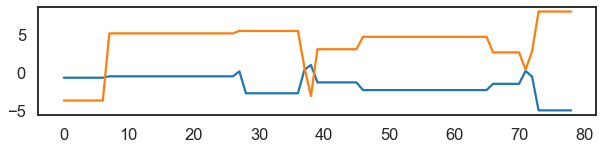

In [51]:
plt.figure(figsize=(10,2))
plt.plot(diff_agrid4[:,0])
plt.plot(diff_agrid4[:,1])

In [128]:
diff_agrid4[:,:2]

array([[-0.6489862 , -3.64910426],
       [-0.6489862 , -3.64910426],
       [-0.6489862 , -3.64910426],
       [-0.6489862 , -3.64910426],
       [-0.6489862 , -3.64910426],
       [-0.6489862 , -3.64910426],
       [-0.6489862 , -3.64910426],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [-0.46119209,  5.18574279],
       [ 0.18238303,  5.52684778],
       [-2.69482686,

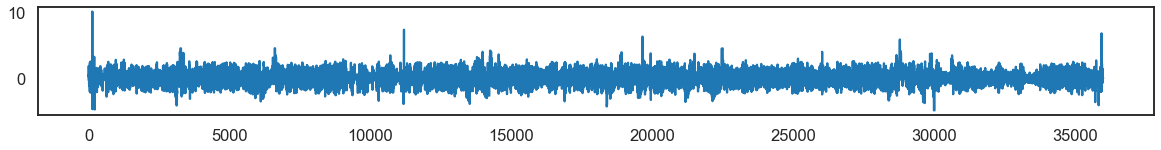

In [54]:
plt.figure(figsize=(20,2))
plt.plot(diff[:,0])

In [82]:
dXY.shape

(900, 2, 4)

In [131]:
dXY[30*10+11:30*10+20][:,0, :2]

array([[-0.24333487,  3.34068912],
       [-0.43041074,  3.37231726],
       [-0.61320553,  3.40113734],
       [-0.79236578,  3.42705845],
       [-0.96853881,  3.45002494],
       [-1.14235716,  3.47000349],
       [-1.31442574,  3.4869743 ],
       [-1.4853105 ,  3.50092635],
       [-1.65552768,  3.51185639]])

In [132]:
dXY[30*15+11:30*15+20][:,0,:2]

array([[-0.09040653,  2.71500893],
       [-0.28361839,  2.72845793],
       [-0.47275202,  2.74290027],
       [-0.65853789,  2.75840567],
       [-0.84175532,  2.7749647 ],
       [-1.0232046 ,  2.79248694],
       [-1.20368015,  2.81080003],
       [-1.38394427,  2.82964963],
       [-1.56470113,  2.84870075]])

In [133]:
dXY[30*19+11:30*19+20][:,0,:2]

array([[-0.07462096,  2.05667884],
       [-0.2525216 ,  2.05125201],
       [-0.42509723,  2.05130559],
       [-0.59376795,  2.05708639],
       [-0.75998268,  2.06867337],
       [-0.9252024 ,  2.08598741],
       [-1.0908858 ,  2.10879298],
       [-1.25847338,  2.13669178],
       [-1.42936615,  2.16910939]])

In [125]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7253, 0.7022, 0.9184, 0.8498],
        [1.8917, 1.9587, 3.1338, 3.1838]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [130]:
[sum(z==k) for k in range(K)]

[24582, 11418]

In [138]:
dXY_sample = np.diff(sample_x_center, axis=0)

In [165]:
XY_next[465,0,:2]

tensor([169.1582, 199.3267], dtype=torch.float64, grad_fn=<SliceBackward>)

In [164]:
XY[465,:2]

array([170.        , 196.55172414])

In [166]:
dXY[465,0,:2]

array([-0.84175532,  2.7749647 ])

In [200]:
dist = TruncatedNormal(mus=XY_next[465,0,:2], 
                       log_sigmas=model.observation.log_sigmas[0,:2], bounds=model.observation.bounds[:2])

In [201]:
model.observation.bounds[:2]

tensor([[ 10., 320.],
        [-10., 390.]], dtype=torch.float64)

In [202]:
d_samples = dist.sample((1000,2))

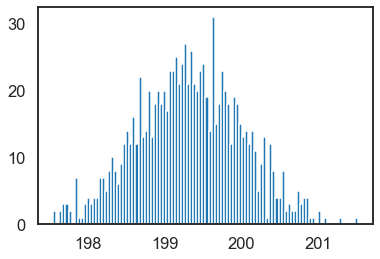

In [204]:
plt.hist(d_samples.numpy()[:,1], bins=100);

In [48]:
torch.exp(model.observation.log_sigmas)

tensor([[0.7253, 0.7022, 0.9184, 0.8498],
        [1.8917, 1.9587, 3.1338, 3.1838]], dtype=torch.float64,
       grad_fn=<ExpBackward>)

In [205]:
model.observation.log_sigmas.shape

torch.Size([2, 4])

In [49]:
joblib.dump(model, "model_k2")

['model_k2']

In [51]:
model_r = joblib.load("model_k2")

In [52]:
for p1, p2 in zip(model.params_unpack, model_r.params_unpack):
    assert torch.all(torch.eq(p1, p2))